In [16]:
import pandas as pd
df = pd.read_excel('Nifty_data_2021_2025.xlsx')
df.head()

,Date,Close,High,Low,Open,Volume
0,2021-01-01,14018.500000,14049.849609,13991.349609,13996.099609,358100
1,2021-01-04,14132.900391,14147.950195,13953.750000,14104.349609,495000
2,2021-01-05,14199.500000,14215.599609,14048.150391,14075.150391,492500
3,2021-01-06,14146.250000,14244.150391,14039.900391,14240.950195,632300
4,2021-01-07,14137.349609,14256.250000,14123.099609,14253.750000,559200


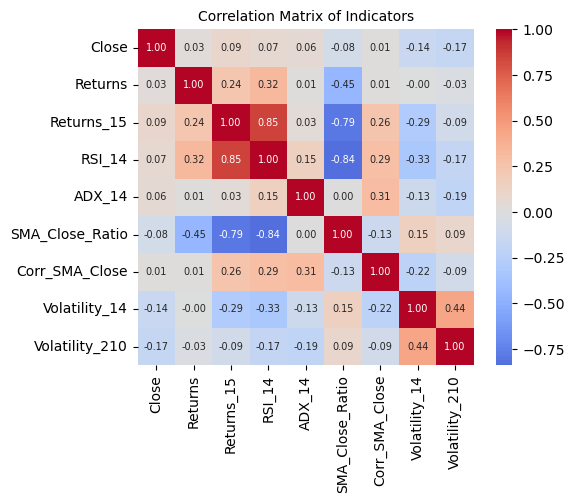


Indicator Statistics:
         Returns  Returns_15     RSI_14     ADX_14  SMA_Close_Ratio  \
count  1062.0000   1062.0000  1062.0000  1062.0000        1062.0000   
mean      0.0005      0.0077    54.9978    23.9574           0.9971   
std       0.0089      0.0324    12.6409     8.3472           0.0175   
min      -0.0593     -0.0926    22.4323     8.7756           0.9540   
25%      -0.0042     -0.0149    45.7357    17.9028           0.9845   
50%       0.0006      0.0079    55.1409    22.5350           0.9956   
75%       0.0059      0.0310    64.3558    28.0449           1.0078   
max       0.0382      0.0986    85.5987    50.1896           1.0605   

       Corr_SMA_Close  Volatility_14  Volatility_210  
count       1062.0000      1062.0000       1062.0000  
mean           0.3557         0.1323          0.2761  
std            0.4948         0.0561          0.1148  
min           -0.9055         0.0442          0.0873  
25%           -0.0096         0.0939          0.1966  
50%    

In [17]:
import pandas as pd
import numpy as np
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import seaborn as sns
import matplotlib.pyplot as plt
from ta.momentum import RSIIndicator
from ta.trend import ADXIndicator
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

sns.set_palette("husl")

TRADING_DAYS_PER_YEAR = 252

try:
    df = pd.read_excel('Nifty_data_2021_2025.xlsx')
except Exception as e:
    print(f"Error loading CSV: {e}")
    print("Ensure 'Nifty_data_2021_2025.xlsx' exists")
    exit(1)

date_col = 'Date' if 'Date' in df.columns else None

try:
    df[date_col] = pd.to_datetime(df[date_col], format='%Y-%m-%d', errors='raise')
    df.set_index(date_col, inplace=True)
except Exception as e:
    print(f"Error parsing '{date_col}' column: {e}")
    print(f"Sample '{date_col}' values:\n", df[date_col].head(10))
    print("Ensure dates are in 'YYYY-MM-DD' format (e.g., '2021-01-01')")
    exit(1)

required_cols = ['Open', 'High', 'Low', 'Close', 'Volume']
missing_cols = [col for col in required_cols if col not in df.columns]
if missing_cols:
    print(f"Error: Missing required columns: {missing_cols}")
    print("Available columns:", df.columns.tolist())
    print("Sample data:\n", df.head(10))
    exit(1)

df = df[required_cols]
df[required_cols] = df[required_cols].interpolate(method='linear')

# Calculate indicators
df['Returns'] = df['Close'].pct_change()
df['Returns_15'] = df['Close'].pct_change(periods=15)
df['RSI_14'] = RSIIndicator(close=df['Close'], window=14).rsi()
df['ADX_14'] = ADXIndicator(high=df['High'], low=df['Low'], close=df['Close'], window=14).adx()
df['SMA_14'] = df['Close'].rolling(window=14).mean()
df['SMA_Close_Ratio'] = df['SMA_14'] / df['Close']
df['Corr_SMA_Close'] = df['Close'].rolling(window=14).corr(df['SMA_14'])
df['Volatility_14'] = df['Returns'].rolling(window=14).std() * np.sqrt(TRADING_DAYS_PER_YEAR)
df['Returns_15_Rolling'] = df['Returns_15'].rolling(window=14).std() * np.sqrt(TRADING_DAYS_PER_YEAR)
df['Volatility_210'] = df['Returns_15_Rolling'].rolling(window=15).mean()

df = df.interpolate(method='linear')

# Decision Tree for Predictions
features = ['Returns', 'Returns_15', 'RSI_14', 'ADX_14', 'SMA_Close_Ratio',
            'Corr_SMA_Close', 'Volatility_14', 'Volatility_210',]
X = df[features]

# Generate log returns
df['returns'] = np.log(df['Close'] / df['Close'].shift(1))
# Create target values
df['Target'] = np.where(df.returns.shift(-1) > 0, 1, 0)

# Training data: Jan 1, 2021 to Dec 31, 2023
train_df = df[(df.index >= '2021-01-01') & (df.index < '2024-01-01')]

# Testing data: Jan 1, 2024 to Jun 25, 2025
test_df = df[(df.index >= '2024-01-01') & (df.index <= '2025-06-25')]

X_train = train_df[features]
y_train = train_df['Target'].dropna()
X_test = test_df[features]
y_test = test_df['Target'].dropna()

# Train decision tree
dt = DecisionTreeClassifier(max_depth=4, criterion='gini', random_state=42)
dt.fit(X_train, y_train)

# Predict on full dataset
df['Prediction'] = dt.predict(X)
df['Prediction_Delayed'] = df['Prediction'].shift(1)  # Simulate trading delay
df = df.dropna()

# Update df_plot after adding predictions
df_plot = df.copy()

# Interactive Subplots with Plotly
fig = make_subplots(rows=5, cols=2, subplot_titles=[
    'Close Price', 'Returns', '15-Period Returns', '14-Period RSI',
    '14-Period ADX', 'SMA/Close Ratio', 'SMA-Close Correlation',
    '14-Period Volatility', '210-Period Volatility',])

plots = [
    ('Close', 'Price', 'blue'),
    ('Returns', 'Returns', 'green'),
    ('Returns_15', 'Returns', 'purple'),
    ('RSI_14', 'RSI', 'orange'),
    ('ADX_14', 'ADX', 'red'),
    ('SMA_Close_Ratio', 'Ratio', 'cyan'),
    ('Corr_SMA_Close', 'Correlation', 'magenta'),
    ('Volatility_14', 'Volatility', 'brown'),
    ('Volatility_210', 'Volatility', 'teal')
]

for i, (col, ylabel, color) in enumerate(plots):
    row, col_idx = (i // 2) + 1, (i % 2) + 1
    fig.add_trace(
        go.Scatter(x=df_plot.index, y=df_plot[col], mode='lines', name=col, line=dict(color=color)),
        row=row, col=col_idx
    )
    if col == 'RSI_14':
        fig.add_hline(y=70, line_dash="dash", line_color="red", opacity=0.5, row=row, col=col_idx)
        fig.add_hline(y=30, line_dash="dash", line_color="red", opacity=0.5, row=row, col=col_idx)

fig.update_layout(
    height=1000, width=1000, title_text="NIFTY Daily Technical Indicators - Trends",
    showlegend=True, template='plotly_white'
)
fig.show()

# Correlation matrix
corr_cols = ['Close', 'Returns', 'Returns_15', 'RSI_14', 'ADX_14', 'SMA_Close_Ratio',
             'Corr_SMA_Close', 'Volatility_14', 'Volatility_210',]
corr_matrix = df[corr_cols].corr()
plt.figure(figsize=(6, 5))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', center=0, fmt='.2f', square=True, annot_kws={"size": 7})
plt.title('Correlation Matrix of Indicators', fontsize=10)
plt.tight_layout()
plt.show()

# Basic statistics
print("\nIndicator Statistics:")
print(df[corr_cols[1:]].describe().round(4))

**Returns**: Measures daily price change (%). Captures
short-term momentum.

**Returns_15**: 15-day price change (%). Captures medium-term momentum.

**RSI_14**: Relative Strength Index (0–100). Identifies overbought (>70) or oversold (<30) conditions.

**ADX_14**: Average Directional Index (0–100). Measures trend strength (>25 = strong trend).

**SMA_14**: 14-day Simple Moving Average. Smooths price to identify trends.

**SMA_Close_Ratio**: Ratio of SMA to Close. Indicates if price is above/below the trend.

**Corr_SMA_Close**: Correlation between Close and SMA. Measures trend stability.

**Volatility_14**: Annualized 14-day volatility. Gauges market risk.

**Returns_15_Rolling**: Volatility of 15-day returns. Captures medium-term risk.

**Volatility_210**: Smoothed volatility (15-day mean of Returns_15_Rolling). Tracks long-term risk.



Decision Tree Accuracy: 0.4573

Classification Report:
              precision    recall  f1-score   support

           0       0.35      0.16      0.22       173
           1       0.49      0.73      0.59       190

    accuracy                           0.46       363
   macro avg       0.42      0.44      0.40       363
weighted avg       0.42      0.46      0.41       363



Top Features Used by the Decision Tree:
           Feature  Importance
3           ADX_14    0.300144
0          Returns    0.202714
6    Volatility_14    0.144517
4  SMA_Close_Ratio    0.103986
5   Corr_SMA_Close    0.075624
1       Returns_15    0.064714
2           RSI_14    0.061382
7   Volatility_210    0.046920


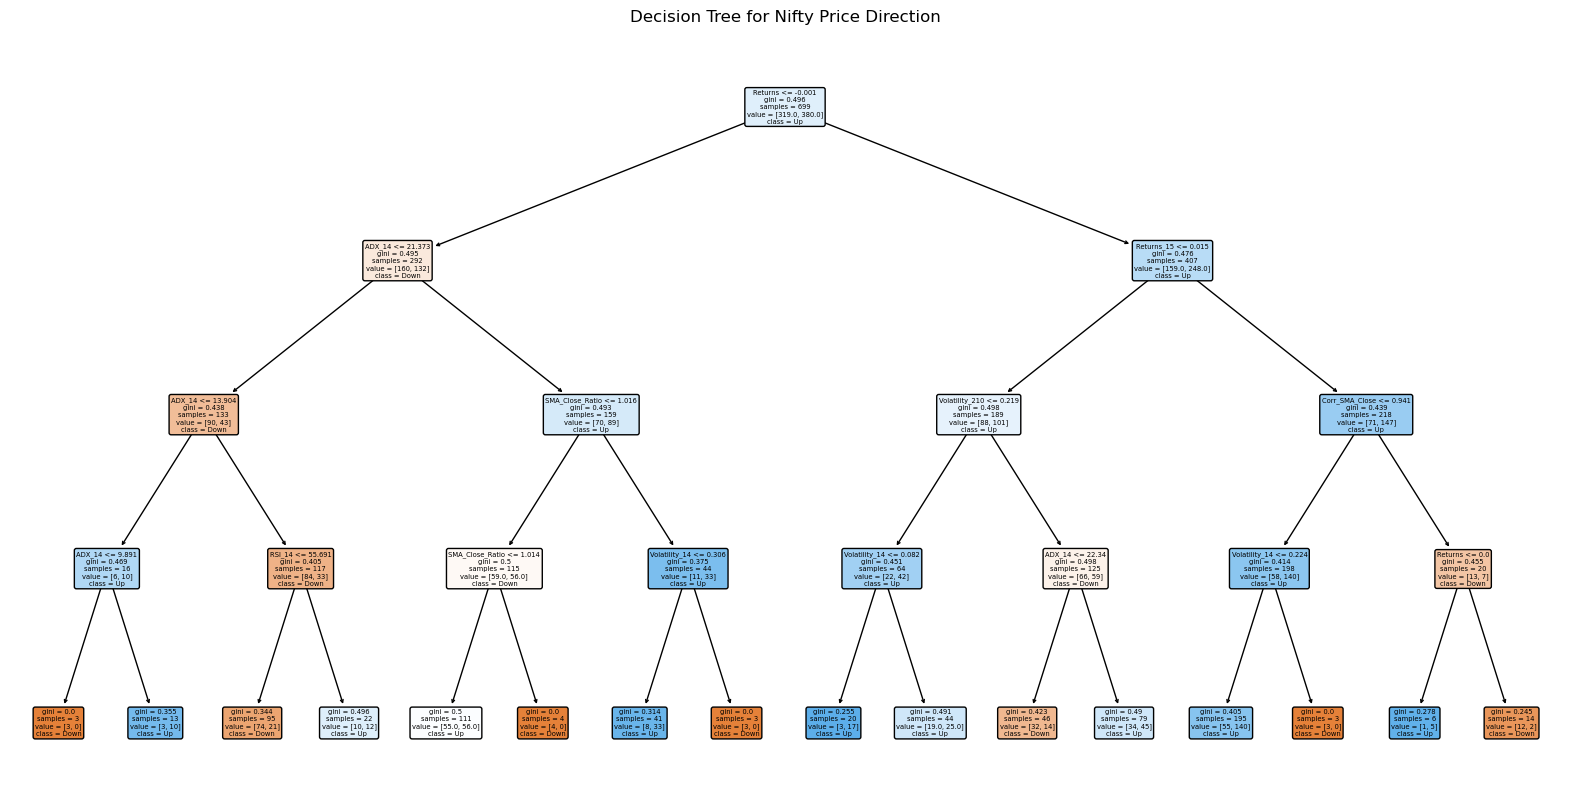


Decision Tree Rules:

|--- Returns <= -0.00
|   |--- ADX_14 <= 21.37
|   |   |--- ADX_14 <= 13.90
|   |   |   |--- ADX_14 <= 9.89
|   |   |   |   |--- class: 0
|   |   |   |--- ADX_14 >  9.89
|   |   |   |   |--- class: 1
|   |   |--- ADX_14 >  13.90
|   |   |   |--- RSI_14 <= 55.69
|   |   |   |   |--- class: 0
|   |   |   |--- RSI_14 >  55.69
|   |   |   |   |--- class: 1
|   |--- ADX_14 >  21.37
|   |   |--- SMA_Close_Ratio <= 1.02
|   |   |   |--- SMA_Close_Ratio <= 1.01
|   |   |   |   |--- class: 1
|   |   |   |--- SMA_Close_Ratio >  1.01
|   |   |   |   |--- class: 0
|   |   |--- SMA_Close_Ratio >  1.02
|   |   |   |--- Volatility_14 <= 0.31
|   |   |   |   |--- class: 1
|   |   |   |--- Volatility_14 >  0.31
|   |   |   |   |--- class: 0
|--- Returns >  -0.00
|   |--- Returns_15 <= 0.01
|   |   |--- Volatility_210 <= 0.22
|   |   |   |--- Volatility_14 <= 0.08
|   |   |   |   |--- class: 1
|   |   |   |--- Volatility_14 >  0.08
|   |   |   |   |--- class: 1
|   |   |--- Volati

In [18]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
import plotly.express as px
import matplotlib.pyplot as plt
from sklearn.tree import plot_tree

#  Define target: 1 if next day's close > current close, 0 otherwise
df['Target'] = (df['Close'].shift(-1) > df['Close']).astype(int)

# Interpolate NaN values
df[['Open', 'High', 'Low', 'Close', 'Volume', 'Target']] = df[['Open', 'High', 'Low', 'Close', 'Volume', 'Target']].interpolate(method='linear')

# Features for the decision tree
features = ['Returns', 'Returns_15', 'RSI_14', 'ADX_14', 'SMA_Close_Ratio',
            'Corr_SMA_Close', 'Volatility_14', 'Volatility_210',]
X = df[features]
y = df['Target']

# Training data: Jan 1, 2021 to Dec 31, 2023
train_df = df[(df.index >= '2021-01-01') & (df.index < '2024-01-01')]

# Testing data: Jan 1, 2024 to Jun 25, 2025
test_df = df[(df.index >= '2024-01-01') & (df.index <= '2025-06-25')]

X_train = train_df[features]
y_train = train_df['Target']
X_test = test_df[features]
y_test = test_df['Target']

# Train decision tree with Gini criterion and max depth 4
dt = DecisionTreeClassifier(max_depth=4, criterion='gini', random_state=42)  # Explicitly set Gini
dt.fit(X_train, y_train)

# Predict and evaluate
y_pred = dt.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print("\nDecision Tree Accuracy:", round(accuracy, 4))
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

# Feature importance
feature_importance = pd.DataFrame({
    'Feature': features,
    'Importance': dt.feature_importances_
}).sort_values(by='Importance', ascending=False)

# Visualize feature importance with Plotly
fig_importance = px.bar(
    feature_importance,
    x='Importance',
    y='Feature',
    title='Feature Importance in Decision Tree',
    orientation='h',
    color='Importance',
    color_continuous_scale='Viridis'
)
fig_importance.update_layout(
    width=800, height=400,
    xaxis_title="Importance",
    yaxis_title="Feature",
    template="ggplot2"
)
fig_importance.show()

print("Top Features Used by the Decision Tree:")
print(feature_importance)


# Visualize decision tree
plt.figure(figsize=(20, 10))
plot_tree(dt, feature_names=features, class_names=['Down', 'Up'], filled=True, rounded=True)
plt.title("Decision Tree for Nifty Price Direction")
plt.show()

from sklearn.tree import export_text

tree_rules = export_text(dt, feature_names=features)
print("\nDecision Tree Rules:\n")
print(tree_rules)


In [15]:
from tabulate import tabulate
def calculate_kpis(df, y_pred):
    returns = df['Returns'].interpolate(method='linear')
    total_return = (df['Close'].iloc[-1] / df['Close'].iloc[0] - 1) * 100 if len(df) > 1 else np.nan
    cagr = ((df['Close'].iloc[-1] / df['Close'].iloc[0]) ** (252 / len(df))) * 100 - 100 if len(df) > 1 else np.nan

    drawdown = (df['Close'] / df['Close'].cummax()) - 1
    max_drawdown = drawdown.min() * 100

    win_rate = (y_pred == 1).mean() * 100 if len(y_pred) > 0 else np.nan
    volatility = returns.std() * np.sqrt(252) * 100 if returns.std() != 0 else np.nan
    profit_factor = np.nan
    psbbr = np.nan
    psbbs = np.nan
    sharpe = (returns.mean() * 252) / (returns.std() * np.sqrt(252)) if returns.std() != 0 else np.nan

    return {
        'Sharpe Ratio': sharpe,
        'Total Return [%]': total_return,
        'CAGR [%]': cagr,
        'Max Drawdown [%]': max_drawdown,
        'Win Rate [%]': win_rate,
        'Profit Factor': profit_factor,
        'Volatility [%]': volatility,
        'PSBBR [%]': psbbr,
        'PSBBS [%]': psbbs
    }

y_pred_train = dt.predict(X_train)
y_pred_test = dt.predict(X_test)

train_kpis = calculate_kpis(train_df, y_pred_train)
test_kpis = calculate_kpis(test_df, y_pred_test)

benchmark_train = {
    'Sharpe Ratio': 0.1,
    'Total Return [%]': 7.17,
    'CAGR [%]': 4.96,
    'Max Drawdown [%]': -14.31,
    'Win Rate [%]': 'NA',
    'Profit Factor': 1.08,
    'Volatility [%]': 18.27,
    'PSBBR [%]': 'NA',
    'PSBBS [%]': 'NA'
}

benchmark_test = {
    'Sharpe Ratio': 2.36,
    'Total Return [%]': 34.23,
    'CAGR [%]': 22.95,
    'Max Drawdown [%]': -7.02,
    'Win Rate [%]': 'NA',
    'Profit Factor': 1.63,
    'Volatility [%]': 10.23,
    'PSBBR [%]': 'NA',
    'PSBBS [%]': 'NA'
}

def extract_scalar(val):
    if isinstance(val, pd.Series):
        return val.iloc[0] if not val.empty else np.nan
    return val

def under_overperforms(strategy, benchmark):
    if isinstance(strategy, pd.Series):
        strategy = strategy.iloc[0] if not strategy.empty else np.nan
    if isinstance(benchmark, pd.Series):
        benchmark = benchmark.iloc[0] if not benchmark.empty else np.nan
    if pd.isna(strategy) or pd.isna(benchmark) or str(benchmark) == 'NA':
        return 'NA'
    elif isinstance(strategy, (int, float)) and isinstance(benchmark, (int, float)):
        if strategy > benchmark:
            return 'OVER'
        elif strategy < benchmark:
            return 'UNDER'
        else:
            return 'EQUAL'
    return 'NA'

df_kpis = pd.DataFrame({
    'KPIs': list(train_kpis.keys()),
    'Benchmark (Train)': [round(benchmark_train[k], 2) if isinstance(benchmark_train[k], (int, float)) else benchmark_train[k] for k in train_kpis.keys()],
    'Training Strategy': [round(train_kpis[k], 2) if isinstance(train_kpis[k], (int, float)) else train_kpis[k] for k in train_kpis.keys()],
    'Training Under/Overperforms': [
        under_overperforms(train_kpis[k], benchmark_train[k]) for k in train_kpis.keys()
    ],
    'Benchmark (Test)': [round(benchmark_test[k], 2) if isinstance(benchmark_test[k], (int, float)) else benchmark_test[k] for k in train_kpis.keys()],
    'Testing Strategy': [round(test_kpis[k], 2) if isinstance(test_kpis[k], (int, float)) else test_kpis[k] for k in train_kpis.keys()],
    'Testing Under/Overperforms': [
        under_overperforms(test_kpis[k], benchmark_test[k]) for k in train_kpis.keys()
    ]
})

df_kpis['Training Under/Overperforms'] = [under_overperforms(train_kpis[k], benchmark_train[k]) for k in train_kpis.keys()]
df_kpis['Testing Under/Overperforms'] = [under_overperforms(test_kpis[k], benchmark_test[k]) for k in train_kpis.keys()]

print("\nKPIs Table - Training Dataset vs Testing Dataset")
print("\n" + pd.Timestamp.now().strftime('%Y-%m-%d %H:%M:%S IST') + " - Table Generated")
print(tabulate(df_kpis, headers='keys', tablefmt='pretty', floatfmt='.2f', showindex=False))


KPIs Table - Training Dataset vs Testing Dataset

2025-07-24 18:14:45 IST - Table Generated
+------------------+-------------------+-------------------+-----------------------------+------------------+------------------+----------------------------+
|       KPIs       | Benchmark (Train) | Training Strategy | Training Under/Overperforms | Benchmark (Test) | Testing Strategy | Testing Under/Overperforms |
+------------------+-------------------+-------------------+-----------------------------+------------------+------------------+----------------------------+
|   Sharpe Ratio   |        0.1        |       1.03        |            OVER             |       2.36       |       0.74       |           UNDER            |
| Total Return [%] |       7.17        |       42.54       |            OVER             |      34.23       |      14.86       |           UNDER            |
|     CAGR [%]     |       4.96        |       13.63       |            OVER             |      22.95       |      10